## Prepare data

source: https://medium.freecodecamp.org/learn-tensorflow-the-word2vec-model-and-the-tsne-algorithm-using-rock-bands-97c99b5dcb3a

In [1]:
# import sqlite3 database

import sqlite3 as sql
import numpy as np

db = sql.connect('./database.sqlite')
cursor = db.cursor()

print(db)

In [4]:
# build Artist class

artist_dict, artist_lookup = {}, {}

class Artist:
    def __init__(self, name):
        self.name = name
        self.reviews = []
        self.genres = []
        self.scores = []
        
    def add_review(self, review):
        self.reviews.append(review)
        
    def add_genre(self, genre):
        self.genres.append(genre)
        
    def add_score(self, score):
        self.scores.append(score)
        
    def __str__(self):
        return self.name

In [13]:
# reading db and store into Artist class

cursor.execute('select reviews.reviewid, artist, genre, score from reviews join genres on genres.reviewid=reviews.reviewid')

for row in cursor:
    if row[1] not in artist_dict:
        artist_dict[row[1]] = Artist(row[1])
        artist_dict[row[1]].add_review(row[0])
        artist_dict[row[1]].add_genre(row[2])
        artist_dict[row[1]].add_score(row[3])
        artist_lookup[row[1]] = len(artist_lookup)
    else:
        artist_dict[row[1]].add_review(row[0])
        artist_dict[row[1]].add_genre(row[2])
        artist_dict[row[1]].add_score(row[3])

print(artist_dict['massive attack'].reviews[0])
print(artist_dict['massive attack'].genres[0])
print(artist_dict['massive attack'].scores[0])


22703
electronic
9.3


In [14]:
'''
Add all our artists to the corresponding genre 
and mean score in these dictionaries 
to use later when generating pairs of artists.
'''

genres, genre_lookup, scores = {}, {}, {}

cursor.execute('select distinct genre from genres')
for row in cursor:
    genre_lookup[len(genre_lookup)] = row[0]
    genres[row[0]] = []
    
for i in range(11):
    scores[i] = []
    
# start adding different artists into dictionary

for artist in artist_dict:
    for genre in artist_dict[artist].genres:
        if artist not in genres[genre]:
            genres[genre].append(artist_lookup[artist])
    mean_score = np.mean(artist_dict[artist].scores)
    scores[round(mean_score)].append(artist_lookup[artist])

# print(genres)

# TODO: create pickle so it doesn't have to build dictionary

{'electronic': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 12, 12, 12, 12, 12, 12, 12, 12, 12, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 40, 40, 40, 40, 40, 40, 40, 40, 40, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,

In [15]:
# create a batch

def gen_batch(genres, scores, size, bias):
    #Initialise the numpy arrays - the xs are the target words and the ys the inidividual contexts.
    xs = np.ndarray(shape=(size), dtype=np.int32)
    ys = np.ndarray(shape=(size, 1), dtype=np.int32)
    for idx in range(size):
        b = np.random.randint(10)
        if b < bias:
            genre = np.random.randint(len(genres))
            g1 = np.random.randint(len(genres[genre_lookup[genre]]))
            g2 = np.random.randint(len(genres[genre_lookup[genre]]))
            #Probably an inefficient way to make sure we don't choose the same artist
            while g1 == g2:
                g2 = np.random.randint(len(genres[genre_lookup[genre]]))
            #Adding the artist unique integer id
            xs[idx] = genres[genre_lookup[genre]][g1]
            ys[idx][0] = genres[genre_lookup[genre]][g2]
        else:
            score = np.random.randint(len(scores))
            s1 = np.random.randint(len(scores[score]))
            s2 = np.random.randint(len(scores[score]))
            while s1 == s2:
                s2 = np.random.randint(len(scores[score]))
            xs[idx] = scores[score][s1]
            ys[idx][0] = scores[score][s2]
    return xs, ys

#A useful dictionary to go from unique integer to artist name
artist_decode = dict(zip(artist_lookup.values(), artist_lookup.keys()))

## Build TF Model

In [16]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10131597733207091945
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11056874295151027339
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8170847250723506703
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10913975501
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6065415888972186679
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [17]:
#Before we dive in we need to declare some variables
vocabulary_size = len(artist_lookup)
#How big we want our final vectors to be
embedding_size = 64
#The number of training samples passed per epoch
batch_size = 64
#Number of negative samples to use in NCE [see below]
num_sampled = 16

#BAND2VEC - Tensorflow Time!
import tensorflow as tf
import math 

graph = tf.Graph()

with graph.as_default():
    #Defining variables and functions in a scope is good practice - adds a prefix to the operations
    with tf.name_scope('inputs'):
        #Tensorflow Placeholders are the mouths of the neural network - they will constantly be fed new information
        training_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        training_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    #Using the CPU
    with tf.device('/gpu:0'):
        with tf.name_scope('embeddings'):
            #The embeddings - variables are maintained across runs and need to be initialised with a shape and type
            #Each row is a band represented by a vector of length 'embedding_size'
            embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            #Like passing muliple indices to a numpy array we get the vectors quickly with this function
            embed = tf.nn.embedding_lookup(embeddings, training_inputs)
        
        with tf.name_scope('weights'):
            #Like embeddings we initialise our weights and also...
            nce_weights = tf.Variable(
                tf.truncated_normal(
                    [vocabulary_size, embedding_size],
                    stddev=1.0 / math.sqrt(embedding_size)))
            
        with tf.name_scope('biases'):
            #...our biases
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
            
    with tf.name_scope('loss'):
        #Finally our loss function - see below for an explanation of the Noise Contrastive Estimation Approach
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=training_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size))
        
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)


In [18]:
#Running our Neural Network!
#First we init the session
iterations = 100000

with tf.Session(graph=graph) as sess:
    #We run the initialize all global variables operation
    sess.run(tf.global_variables_initializer())
    average_loss = 0.0
    #For all of the iterations
    for index in range(iterations):
        #Generate a batch
        ti, tl = gen_batch(genres, scores, batch_size, 8)
        #Put these in our feed dictionary
        feed_dict = {training_inputs: ti, training_labels: tl}
        #Run the NN! Notice the feed dict feeding our placeholders from before
        _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
        #Some metrics so we can see how we're doing
        average_loss += loss_val
        if (index + 1) % 2000 == 0:
            print('Average loss at step', index + 1, average_loss / (index + 1))
    #Returns our Embeddings so we can access them       
    final_embeddings = embeddings.eval()

Average loss at step 2000 32.95757746577263
Average loss at step 4000 23.252939480543137
Average loss at step 6000 18.015084751208622
Average loss at step 8000 14.791214270070196
Average loss at step 10000 12.63853492769003
Average loss at step 12000 11.110443091303111
Average loss at step 14000 9.95238900807074
Average loss at step 16000 9.051835620678961
Average loss at step 18000 8.331411337825987
Average loss at step 20000 7.7421250700712205
Average loss at step 22000 7.245676744114269
Average loss at step 24000 6.827610947497189
Average loss at step 26000 6.466816719983632
Average loss at step 28000 6.153257115872843
Average loss at step 30000 5.878205808653434
Average loss at step 32000 5.634503902317956
Average loss at step 34000 5.416214054474059
Average loss at step 36000 5.220462776680788
Average loss at step 38000 5.043113035122031
Average loss at step 40000 4.880869991581142
Average loss at step 42000 4.734815010385854
Average loss at step 44000 4.599549410473217
Average lo

## Visualize with tSNE

In [19]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, verbose=1, init='pca', n_iter=500, method='exact')
    plot_only = len(artist_lookup)
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 8715
[t-SNE] Computed conditional probabilities for sample 2000 / 8715
[t-SNE] Computed conditional probabilities for sample 3000 / 8715
[t-SNE] Computed conditional probabilities for sample 4000 / 8715
[t-SNE] Computed conditional probabilities for sample 5000 / 8715
[t-SNE] Computed conditional probabilities for sample 6000 / 8715
[t-SNE] Computed conditional probabilities for sample 7000 / 8715
[t-SNE] Computed conditional probabilities for sample 8000 / 8715
[t-SNE] Computed conditional probabilities for sample 8715 / 8715
[t-SNE] Mean sigma: 1.104459
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.105713
[t-SNE] Error after 500 iterations: 3.473261


In [20]:
#Given a low dimension embedding, find the clostest point to it using Euclidean Distance
from sklearn.metrics.pairwise import euclidean_distances
def find_closest_n(band_embedding, n=1):
    closest = []
    for idx, lde in enumerate(low_dim_embs):
        differences = euclidean_distances([band_embedding], low_dim_embs)
        idxs = np.argsort(differences)
    for i in idxs[0, :n]:
        closest.append(artist_decode[i])
    return closest


def top_n_similar_artists(word, n):
    index = artist_lookup[word]
    vector_representation = low_dim_embs[index]
    esim = euclidean_distances([vector_representation], low_dim_embs)
    eindices = np.argsort(esim)
    top_n = []
    for id1 in eindices[0][:n]:
        top_n.append(artist_decode[id1])
    return top_n

In [21]:
#Kmeans - https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=len(genres))
kmeans.fit(low_dim_embs)
y_kmeans = kmeans.predict(low_dim_embs)

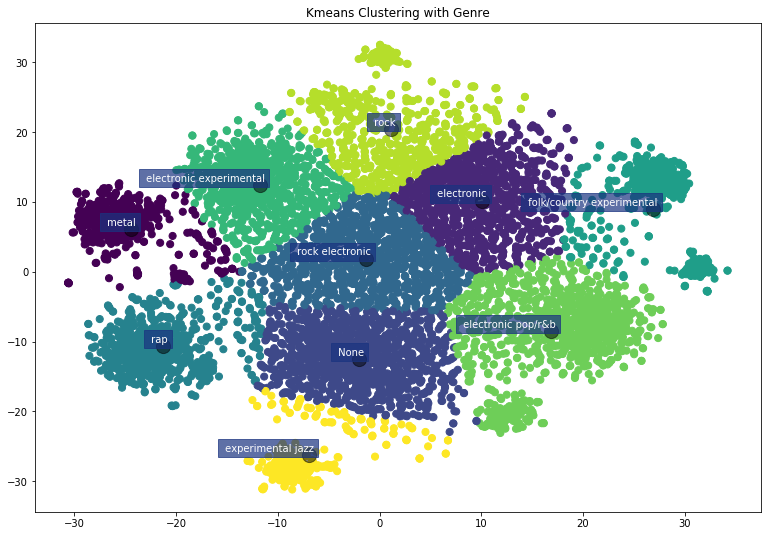

In [22]:
ig, ax = plt.subplots(figsize=(13, 9))
ax.scatter(low_dim_embs[:, 0], low_dim_embs[:, 1], c=y_kmeans, s=50, cmap='viridis')

centres = kmeans.cluster_centers_
centres_labels = []
for centre in centres:
    top_5 = find_closest_n(centre, 5)
    labels = ""
    for artist in top_5:
        g = artist_dict[artist].genres[0]
        if g == None: 
            g = 'None'
        if g not in labels.split(): 
            labels += (' ' + (g))
    centres_labels.append(labels)
    
for idx, label in enumerate(centres_labels):
        x, y = centres[idx, :]
        ax.scatter(x, y, c='black', s=200, alpha=0.5)
        ax.annotate(label,xy=(x, y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom', color='white', backgroundcolor=(0.1, 0.2, 0.5, 0.7)) 
        
ax.set_title('Kmeans Clustering with Genre')
plt.savefig('./KMEANS_CLUSTERING.png')

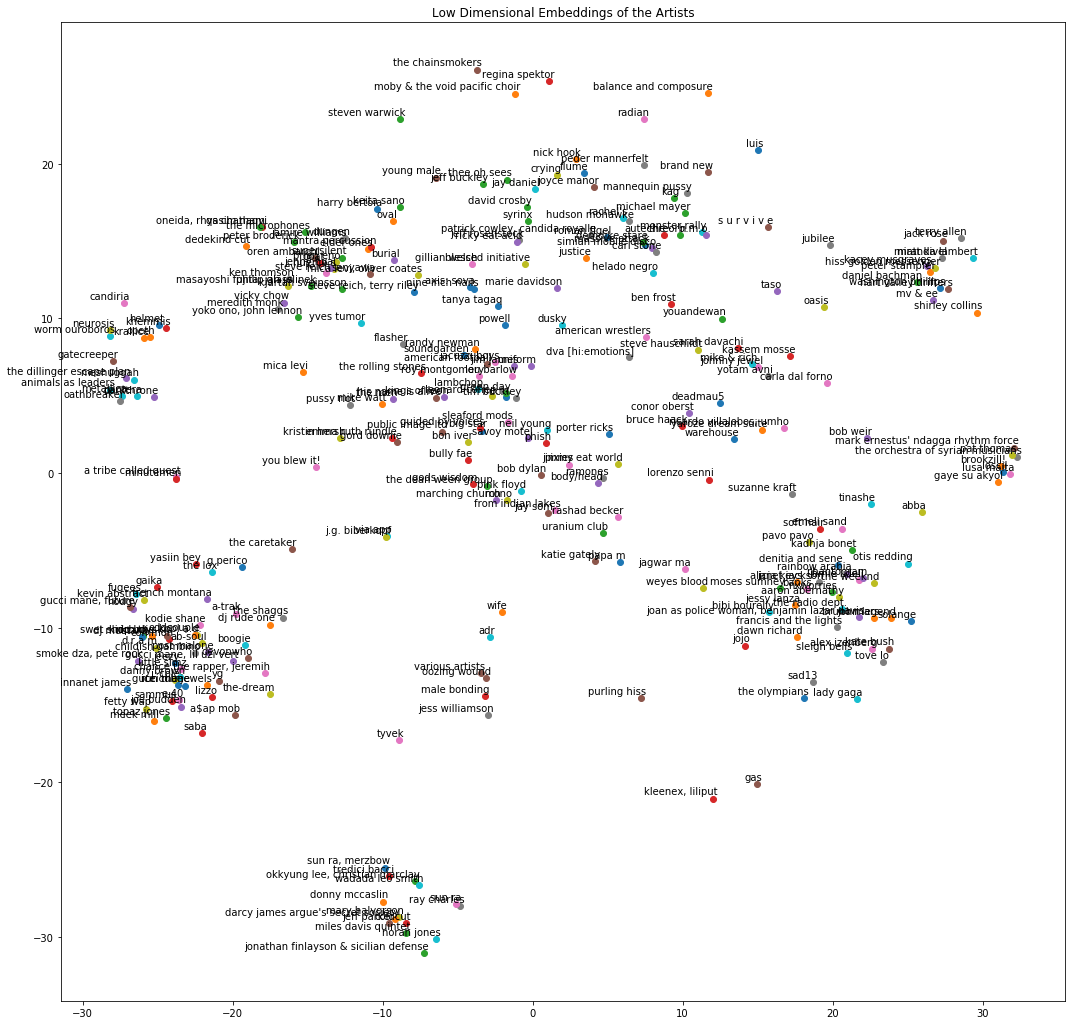

In [23]:
from tempfile import gettempdir
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',ha='right',va='bottom')
    plt.title('Low Dimensional Embeddings of the Artists')
    #plt.show()
    plt.savefig('./FIRST_300.png')

labels = []
for i in range(300):
    if artist_decode[i] != 'joey bada$$':
        labels.append(artist_decode[i])
plot_with_labels(low_dim_embs, labels, './other.png')

In [24]:
print(artist_dict['coil'].genres, np.mean(artist_dict['coil'].scores))
print(artist_dict['elder ones'].genres, np.mean(artist_dict['elder ones'].scores))
electronic_experimental = low_dim_embs[artist_lookup['coil']] - low_dim_embs[artist_lookup['elder ones']]

['electronic', 'experimental', 'rock', 'electronic', 'experimental', 'rock', 'electronic', 'experimental', 'rock', 'electronic', 'experimental', 'rock', 'electronic', 'experimental', 'rock', 'electronic', 'experimental', 'rock', 'electronic', 'experimental', 'rock', 'electronic', 'experimental', 'rock', 'electronic', 'experimental', 'rock'] 7.900000000000001
['experimental', 'experimental', 'experimental', 'experimental', 'experimental', 'experimental', 'experimental', 'experimental', 'experimental'] 7.800000000000001


In [25]:
bands = find_closest_n(electronic_experimental, 3)
for band in bands:
    print(band, 'Mean Score:' , np.mean(artist_dict[band].scores), 'Genres:', artist_dict[band].genres)

mclusky Mean Score: 8.0 Genres: [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
skywave Mean Score: 7.5 Genres: [None, None, None, None, None, None, None, None, None]
mason bates Mean Score: 7.5 Genres: [None, None, None, None, None, None, None, None, None]


In [27]:
!jupyter nbconvert --to html TF, Word2Vec, tSNE.ipynb

[NbConvertApp] WARNING | pattern 'TF,' matched no files
[NbConvertApp] WARNING | pattern 'Word2Vec,' matched no files
[NbConvertApp] WARNING | pattern 'tSNE.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--debug
    set log level to logging.DEBUG (maximize logging output)
--generate-config
    generate default config file
-y
    Answer yes to any questions instead of prompting.
--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--stdin
    read a single notebook file from std